<a href="https://colab.research.google.com/github/Czyundream/Leetcodetest/blob/main/%E6%9D%8E%E6%B2%90%E2%80%94%E7%BA%BF%E5%BD%A2%E5%9B%9E%E5%BD%92%E9%83%A8%E5%88%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [29]:
#线形回归从零开始实现
import torch
%matplotlib inline
import random
from d2l import torch as d2l

##生成人造数据集
生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。 我们的合成数据集是一个矩阵$𝐗∈\mathbb{R}^{1000×2}$。
使用参数：$\mathbf{w}=[2,-3.4]^{T},b=4.2$和噪声项$\epsilon $生成数据集和标签：  
<center>$\mathbf{y}=\mathbf{X}\mathbf{w}+b+ϵ$

In [30]:
def synthetic_data(w, b, num_examples):
    '''生成y = Xw + b + 噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))#X均值为0，方差为1的随机数，大小是n个样本，列数为w的长度
    y = torch.matmul(X, w) + b
    y +=torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

In [31]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [32]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

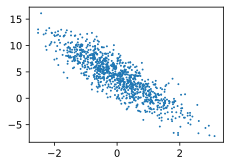

In [33]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);#detach()实现分离数值，不再包含梯度关系

##读取数据集
---
定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [57]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #进行打乱操作
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]#执行分批操作
        )
        yield features[batch_indices], labels[batch_indices]
        #yield就是return一个值，并记录返回的位置，下一次迭代从这个位置开始。

batch_size = 10

#执行读取第一个小批量打印，每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。
'''
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n', y)
    break
'''

"\nfor X, y in data_iter(batch_size, features, labels):\n    print(X,'\n', y)\n    break\n"

当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。 上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。 例如，它要求我们将所有数据加载到内存中，并执行大量的随机内存访问。 在深度学习框架中实现的内置迭代器效率要高得多， 它可以处理存储在文件中的数据和数据流提供的数据。

##初始化模型参数

In [55]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[ 0.0170],
         [-0.0044]], requires_grad=True), tensor([0.], requires_grad=True))

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。

##定义模型

接下来，我们必须定义模型，将模型的输入和参数同模型的输出关联起来。 回想一下，要计算线性模型的输出， 我们只需计算输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后加上偏置$b$。注意，上面$\mathbf{X}$$\mathbf{w}$是一个向量，而$b$是一个标量。  
广播机制：当我们用一个向量加一个标量时，标量会被加到向量的每个分量上。

In [36]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

##定义损失函数
---
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。 这里平方损失函数。在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [37]:
def squared_loss(y_hat, y):
    '''均方误差'''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2 #并没有求均值

##定义优化算法
---
实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [38]:
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size #在这一步进行了求均值
            param.grad.zero_()

##训练过程
---
 理解这段代码至关重要，因为从事深度学习后， 你会一遍又一遍地看到几乎相同的训练过程。 在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。 最后，我们调用优化算法sgd来更新模型参数。在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集， 并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。 这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。 设置超参数很棘手，需要通过反复试验进行调整。 

In [58]:
lr = 0.03#学习率不能太小，也不能太大
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033257
epoch 2, loss 0.000117
epoch 3, loss 0.000050


因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [40]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差：tensor([ 0.0008, -0.0001], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0006], grad_fn=<RsubBackward1>)


学习率不能太小也不能太大
举例：

In [41]:
#每次需要重新随机初始化，避免跟着上一次的梯度结果
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.001#学习率不能太小，也不能太大
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 13.425802
epoch 2, loss 11.025660
epoch 3, loss 9.054631
epoch 4, loss 7.435962
epoch 5, loss 6.106705
epoch 6, loss 5.015083
epoch 7, loss 4.118612
epoch 8, loss 3.382402
epoch 9, loss 2.777807
epoch 10, loss 2.281295


In [42]:
#每次需要重新随机初始化，避免跟着上一次的梯度结果
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 10#学习率不能太小，也不能太大
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():#对数据jingjing
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss nan
epoch 2, loss nan
epoch 3, loss nan
epoch 4, loss nan
epoch 5, loss nan
epoch 6, loss nan
epoch 7, loss nan
epoch 8, loss nan
epoch 9, loss nan
epoch 10, loss nan


##本节思考题
---
1.如果我们将权重初始化为零，会发生什么。算法仍然有效吗？

In [59]:
w = torch.zeros(size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 0.03#学习率不能太小，也不能太大
num_epochs = 3#学习数据几遍
net = linreg
loss = squared_loss

for epoch in range(num_epochs):#第一层实现每一次对所有数据扫一遍
    for X, y in data_iter(batch_size, features, labels):#每一次拿出一个批量大小的X，y 
        l = loss(net(X, w, b), y)#y预测和y的小批量损失
        #此时l形状是（'batch_size'，1），不是一个标量。l中所有元素被加到一起，并以此计算[w, b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)#使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w , b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033461
epoch 2, loss 0.000119
epoch 3, loss 0.000050


#线性回归的简易实现部分
---
（1）通过张量来进行数据存储和线性代数； （2）通过自动微分来计算梯度。 实际上，由于数据迭代器、损失函数、优化器和神经网络层很常用， 现代深度学习库也为我们实现了这些组件。

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [45]:
#生成数据集
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [46]:
def load_array(data_arrays, batch_size, is_train=True):
    '''构造一个PyTorch数据迭代器'''
    dataset = data.TensorDataset(*data_arrays)#将数据转为dataset，*表示将元组拆解为一维数字作为传入参数
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
    #将dataset型数据挑选batch_size大小的样本，shuffle控制是否打乱

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.1553, -0.1649],
         [ 0.7915,  0.6654],
         [-0.2432, -0.9138],
         [-1.0076, -0.8861],
         [ 1.1005,  0.5288],
         [-0.4933, -0.4332],
         [ 0.1949, -0.6182],
         [ 0.7145, -1.2690],
         [-1.0992, -1.0687],
         [ 0.7895,  1.8604]]), tensor([[ 5.0817],
         [ 3.5148],
         [ 6.8115],
         [ 5.1909],
         [ 4.6189],
         [ 4.6608],
         [ 6.6833],
         [ 9.9399],
         [ 5.6375],
         [-0.5504]])]

##模型定义
---
使用框架的预定义好的层

In [47]:
from torch import nn#nn为神经网络的缩写

net = nn.Sequential(nn.Linear(2, 1))#Linear为全连接层，需要指定输入维度和输出维度
#Sequential可以理解为容器，即list of layers

初始化模型参数

In [48]:
net[0].weight.data.normal_(0, 0.01)#normal_为使用正态分布替换掉data的值
net[0].bias.data.fill_(0)#bias为偏差

tensor([0.])

均方误差函数nn里的MSELoss类

In [49]:
loss = nn.MSELoss()

实例化SGD在类optim里即optimize优化

In [50]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)#optim.SGD需要指定两个参数：net.parameters()为拿出所有参数，lr学习率

训练过程

In [51]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss{l:f}')#l:f打印l，格式为浮点数

epoch1, loss0.000216
epoch2, loss0.000100
epoch3, loss0.000100
